In [1]:
import numpy  as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *

from processing import *

%load_ext autoreload
%autoreload 2

## Telescope Setup
Starting with the Magellan pupil (scaled to 3.048 m) till we get a description of the Shane pupil 

In [2]:
pupil_diameter = 3.048 # (meter)
collecting_area = np.pi * (3.048**2 - 0.9779**2)

f_number = 13 # effective focal ratio
effective_focal_length = pupil_diameter * f_number # (meter)

filter_name = 'V'
wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)


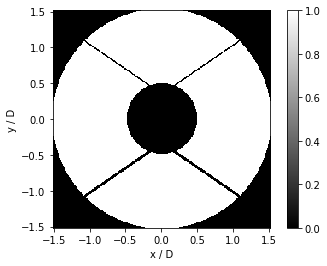

In [3]:
# Generating the pupil grid
grid_size = 256

pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

# Adjust spiders to represent Shane pupil
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray', )
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

## Setting Up the Atmosphere
seeing estimated from the following source: 
https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html

In [4]:
seeing = 1.75
outer_scale = 40. # (meter) --> GUESS, NEEDS REFINING
velocity = 20. # (m/s) --> GUESS, NEEDS REFINING
                                    
fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
                             
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)

tau0 = 0.314 * fried_parameter/velocity

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 6.3cm
L0   = 40.0m
tau0 = 1.0ms
v    = 20.0m/s


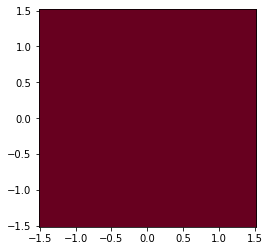

In [5]:
# Generating phase screens
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # (radian)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')

In [6]:
# Propagating to focal plane

nairy = 100

focal_grid = make_focal_grid(q=4, 
                             num_airy=nairy,
                             pupil_diameter=pupil_diameter,
                             focal_length = effective_focal_length,
                             reference_wavelength=wavelength)

prop = FraunhoferPropagator(pupil_grid, focal_grid, 
                            focal_length=effective_focal_length)

## Add a Primary and Companion

In [7]:
# Primary parameters
mag = 17 #Vega magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] #I, Q, U, V

# Companion parameters
contrast = 0.
stokes_ps = [1.,0.,0.,0.] #I, Q, U, V
angular_separation= 2. #Lambda/D

# Exposure time and total number of exposures
exposure_time = 0.01 # (seconds)
exposure_total = 100  

### Simulating Image Data

In [8]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,
                            input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s


wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
                      wavelength,
                      input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,) # (photons/s)

In [9]:
detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)
ims = []
layer.t = exposure_time
for i in range(exposure_total):
    layer.t+=exposure_time
    detector.integrate(prop((layer(pupil_wavefront))),exposure_time)
    detector.integrate(prop((layer(wf_planet))),exposure_time)   
    image_comb = detector.read_out()
    ims.append(image_comb)
    

In [10]:
npix = int(np.sqrt(np.prod(image_comb.shape)))
ims_out = []

for i in range(len(ims)):
    im = ims[i]
    im_out = im.copy().reshape([npix,npix])
    ims_out.append(np.array(im_out))
ims_out_a = np.array(ims_out)

### Image Processing
includes preprocessing, taking FTs, power spectra, and ACFs

In [11]:
# Function Parameters - see processing.py for more detail
# ims           - input image array
# ims_ft        - input FT array
# gsigma        - std deviation for the Gaussian kernel
# subframe_size - final image size in pixels
# HWHM          - half-wavelength at half maximum for supergaussian window
# m             - order of supergaussian window
# scaling       - determines radial cutoff (fcut) for PS

ims_p = image_preprocessing(ims_out_a, 10, 550)
#              parameters: (ims, gsigma, subframe_size)

FT = fourier_transform(ims_p, 100, 4)
#              parameters: (ims, HWHM, m)

PS = power_spectrum(FT, wavelength, pupil_diameter, 1.)
#              parameters: (ims_ft, wavelength, pupil_diameter, scaling, HWHM, m)

ACF = generate_ACF(PS)
#              parameters: (ims_ps)

Text(0, 0.5, 'Mean')

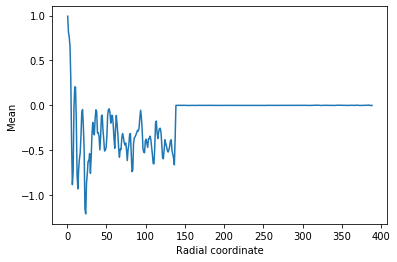

In [12]:
from radial_profile import radial_data

rad_stats = radial_data(PS[0])
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial coordinate')
plt.ylabel('Mean')

### Final Image, PS, and ACF

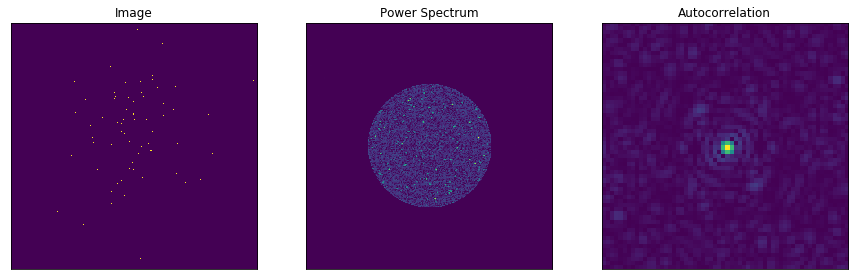

In [13]:
# Image, PS, and ACF plots
f = plt.figure(figsize=(15,5))
ax=f.add_subplot(131)
plt.imshow(ims_p[0])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')

ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS[0]))
ax.set_yticks([])
ax.set_xticks([])

fsub = 30
ax=f.add_subplot(133)
plt.imshow(np.abs(ACF[0])[int(550/2)-fsub:int(550/2)+fsub,int(550/2)-fsub:int(550/2)+fsub])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')
plt.show()

# To save image:
#plt.savefig('speckle_imaging.png')

## Speckle Contrast Curve

In [14]:
# Grid: 800 pixels across, equalling 200 lambda / D, plate scale is then 0.25*lambda / D per pixel
plate_scale = 0.25 * wavelength / pupil_diameter * 206265.   #of image in (arcsec / pixel)

# Plate scale in meters per pixel
ps_mpp = 1. / (npix * plate_scale) * 206265. * wavelength 
scaling = 0.5
fcut = pupil_diameter / ps_mpp * scaling

/Users/Nicole/Desktop/specklepol-master (updated)/processing.py:180: RuntimeWarning: invalid value encountered in sqrt
  ACF_ccs_out = -2.5*np.log10((1.-np.sqrt(1.-(2*ACF)**2))/(2*ACF))


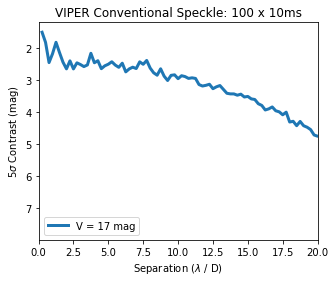

In [15]:
#Generating contrast curves

ACF_m = ACF_cc(ACF[0])
rad_ACF = radial_data(np.abs(ACF[0]), annulus_width=2)
cc = ACF_cc(5*rad_ACF.std)
xax = np.array(range(len(rad_ACF.mean))) * plate_scale / ((wavelength) / pupil_diameter * 206265) #in lambda/D units

f = plt.figure(figsize=(5,4))
plt.plot(xax,cc,label='V = '+str(mag)+' mag',lw=3)
plt.xlim(0.0,20.0)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.ylabel(r'5$\sigma$ Contrast (mag)')
plt.xlabel(r'Separation ($\lambda$ / D)')
plt.title('VIPER Conventional Speckle: 100 x 10ms')
#plt.savefig('speckle_cont_conv_2.png',dpi=300)
plt.show()